In [1]:
%cd /content/drive/MyDrive/boda2

!pip install pytorch-lightning==1.9
!pip install cloudml-hypertune
!pip install dmslogo
!pip install biopython

from google.colab import output
output.clear()

In [2]:
import sys
import os
import subprocess
import tarfile
import shutil
import random
from functools import partial
from tqdm import tqdm
from tqdm.auto import tqdm
tqdm.pandas()

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions.categorical import Categorical
from torch.utils.data import (random_split, DataLoader, TensorDataset, ConcatDataset)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits import mplot3d

import pickle
from datetime import datetime
import scipy.stats as stats
import math

import hypertune
import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger

import boda
from boda.common import constants, utils
from boda.common.utils import *

from src.main import unpack_artifact, model_fn
from src.pymeme import streme, parse_streme_output
from boda.generator.plot_tools import matrix_to_dms, ppm_to_IC, ppm_to_pwm, counts_to_ppm
from boda.data import MPRA_DataModule

from boda.common.utils import batch2fasta

if torch.cuda.is_available():
    use_cuda = True
    torch.backends.cudnn.benchmark = True
    print(f'GPU available: {torch.cuda.get_device_name(0)} ({torch.cuda.device_count()} count)')
else:
    print('No GPU available')

import dmslogo
import matplotlib as mpl
from scipy.ndimage import gaussian_filter1d

import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

%matplotlib inline

GPU available: Tesla V100-SXM2-16GB (1 count)


In [3]:
# class constants():
#     def __init__(self):
#         self.STANDARD_NT = ['A','C','G','T']
#         self.DNA_COMPLEMENTS = {'A':'T', 'G':'C', 'T':'A', 'C':'G'}
# constants = constants()

class utils():
    @staticmethod
    def pad_pssm(row, pad_len=24, column_name='pssm'):
        padded_pssm = np.zeros((4, pad_len))
        padded_pssm[:, 0:row['length']] = row[column_name]
        return padded_pssm

    @staticmethod
    def pad_seq_tensor(seq_tensor, pad_len=217, dim=-1):
        assert seq_tensor.shape[dim] <= pad_len
        padded_tensor = torch.zeros((4, pad_len))
        padded_tensor[:, 0:seq_tensor.shape[dim]] = seq_tensor
        return padded_tensor

    @staticmethod
    def dna2tensor(sequence_str, vocab_list=constants.STANDARD_NT):
        seq_tensor = np.zeros((len(vocab_list), len(sequence_str)))
        for letterIdx, letter in enumerate(sequence_str):
            seq_tensor[vocab_list.index(letter), letterIdx] = 1
        seq_tensor = torch.Tensor(seq_tensor)
        return seq_tensor

    @staticmethod
    def row_dna2tensor(row, in_column_name='padded_seq' , vocab=['A', 'C', 'G', 'T']):
        sequence_str = row[in_column_name]
        seq_idxs = torch.tensor([vocab.index(letter) for letter in sequence_str])
        sequence_tensor = F.one_hot(seq_idxs, num_classes=4).transpose(1,0)
        return sequence_tensor.type(torch.float32)

    @staticmethod
    def append_zero_tensor(row, in_column_name='seq_tensor', target_len=217):
        seq__tensor = row[in_column_name]
        num_zeros = target_len - seq__tensor.shape[-1]
        zeros = torch.zeros((4, num_zeros))
        padded_seq = torch.cat( (seq__tensor, zeros), dim=-1 )
        return padded_seq

    @staticmethod
    def reverse_complement_onehot(x, nt_order=constants.STANDARD_NT,
                              complements=constants.DNA_COMPLEMENTS):
        comp_alphabet = [ complements[nt] for nt in nt_order ]
        permutation = [ nt_order.index(nt) for nt in comp_alphabet ]
        return torch.flip(x[..., permutation, :], dims=[-1])

    @staticmethod
    def append_zero_tensor(row, in_column_name='seq_tensor', target_len=217):
        seq__tensor = row[in_column_name]
        num_zeros = target_len - seq__tensor.shape[-1]
        zeros = torch.zeros((4, num_zeros))
        padded_seq = torch.cat( (seq__tensor, zeros), dim=-1 )
        return padded_seq

def counts_to_ppm(in_tensor):
    motif = in_tensor.div( in_tensor.sum(0) )
    return motif

def ppm_to_pwm(in_tensor,bkg=[0.25,0.25,0.25,0.25]):
    motif = in_tensor.div(torch.tensor(bkg).unsqueeze(1)).log2()
    return motif

def ppm_to_U(in_tensor):
    return (in_tensor.log2() * in_tensor).sum(0).mul(-1.)

def ppm_to_IC(in_tensor):
    return in_tensor * ppm_to_U( in_tensor ).mul(-1.).add(2.)

def tensor_to_pandas(in_tensor, tokens=constants.STANDARD_NT, colors=['green','orange','red','blue']):
    data = []
    my_array = in_tensor.cpu().numpy()
    for nt, score_vec,color in zip(tokens,[ sub_a for sub_a in my_array ],colors):
         _ = [ data.append([j,nt,score,color]) for j,score in enumerate(score_vec) ]
    return pd.DataFrame(data=data,columns=['site', 'letter', 'height','color'])

def matrix_to_dms(in_tensor, ax=None, y_max=2, fontaspect=.55, widthscale=0.8,
                  axisfontscale=0.6, heightscale=0.8, colors=['green','blue','orange','red']):
    motif = tensor_to_pandas(in_tensor, colors=colors)
    fig, ax = dmslogo.draw_logo(data=motif,
                                x_col='site',
                                letter_col='letter',
                                letter_height_col='height',
                                color_col='color',
                                ax=ax,
                                fixed_ymax=y_max,
                                fontaspect=fontaspect,
                                widthscale=widthscale,
                                axisfontscale=axisfontscale,
                                heightscale=heightscale)
    return fig, ax

def string_to_numpy(text, dtype=None):
    """
    Convert text into 1D or 2D arrays using np.matrix().
    The result is returned as an np.ndarray.
    """
    import re
    text = text.strip()
    # Using a regexp, decide whether the array is flat or not.
    # The following matches either: "[1 2 3]" or "1 2 3"
    is_flat = bool(re.match(r"^(\[[^\[].+[^\]]\]|[^\[].+[^\]])$",
                            text, flags=re.S))
    # Replace newline characters with semicolons.
    text = text.replace("]\n", "];")
    # Prepare the result.
    result = np.asarray(np.matrix(text, dtype=dtype))
    return result.flatten() if is_flat else result

def double_pad_seq_tensor(seq_tensor, pad_len=25):
    total_out_len = 2*pad_len + seq_tensor.shape[-1] - 2
    padded_tensor = torch.zeros((4, total_out_len))
    tensor_start = pad_len-1
    tensor_stop = tensor_start + seq_tensor.shape[-1]
    padded_tensor[..., tensor_start:tensor_stop] = seq_tensor
    return padded_tensor

def str2tensor(array_string):
    return torch.tensor([float(item) for item in array_string.lstrip('[[ ').rstrip(' ]]').split(' ') if item != ''])

# Load Malinois

In [4]:
model_dir = './artifacts'
model = model_fn(model_dir)
model.cuda()
model.eval()
print()

Loaded model from 20211113_021200 in eval mode



# Load CODA library

In [5]:
boda2_df = pd.read_csv('/content/drive/MyDrive/data/BODA2_MPRA/BODA2_MPRA_results_pred_contributions_v1.txt', sep=" ", low_memory=False)

row_filter_1 = boda2_df['method'].isin(['DHS', 'gs', 'sa', 'al']) & (boda2_df['round'] == 0)
coda_library_df = boda2_df[row_filter_1 | (boda2_df['method'] == 'fsp') ].reset_index(drop=True)

coda_library_df['method_round'] = [row['method'] + '_' + str(row['round']) if row['round'] !=0 else row['method'] for _,row in coda_library_df.iterrows()]

cell_types = ['K562', 'HepG2', 'SKNSH']
cell_colors = ['#00A79D', '#FBB040', '#ED1C24']
cell_order = [x.lower() for x in cell_types]
method_order = ['DHS', 'gs', 'sa', 'al', 'fsp', 'fsp_1', 'fsp_2', 'fsp_3', 'fsp_4', 'fsp_5']
method_colors = ['#81BA37', '#5AE7AE', '#D972FF', '#8447FF'] + 6*['#FFB2E6']

# Load CODA contributions

In [6]:
onehots_dict = torch.load('/content/drive/MyDrive/data/BODA2_MPRA/CODA_contributions/CODA_onehots.pt')

contributions_dicts = {}
for cell_type in cell_types:
  contributions_dicts[cell_type] = torch.load(f'/content/drive/MyDrive/data/BODA2_MPRA/CODA_contributions/CODA_contributions_{cell_type}.pt')

all_contributions = torch.stack([contributions_dicts[cell_type]['contributions'] for cell_type in cell_types], dim=0)
all_hyp_contributions = torch.stack([contributions_dicts[cell_type]['hyp_contributions'] for cell_type in cell_types], dim=0)

# Load core motifs

In [7]:
tensor_motif_dict = torch.load("/content/drive/MyDrive/data/BODA2_MPRA/STREME_library_analysis/modisco_plus_streme_core_motif_tensors.pt")
motif_ids = list(tensor_motif_dict.keys())

In [8]:
custom_motif_names = ['GATA3', 'ELK4', 'FOSB::JUNB', 'HNF1B', 'HNF4A', 'CREB1', 'RELA', 'SP1', 'TEAD4',
                      'TP53', 'IRF4', 'STAT1', 'FOXB1', 'NR5A1', 'DBP', 'SOX4', 'SREBF2', 'FOXI1',
                      'TCF7L1', 'EHF', 'FOXJ2', '*NRF1', 'IRF3', 'NFATC2 x2', 'TYY1', 'NRF1', 'POU3F4', 'MEF2B',
                      'GFI1B', 'ID4', '*NFIB', 'STREME_1', 'STREME_2', 'MEIS2', 'STREME_4', '*HSF1'
                      ]

#Get predictions of original sequences

In [9]:
seq_onehots = onehots_dict['onehots']

onehots = seq_onehots.clone()
#--- Predict ----
left_flank = utils.dna2tensor(constants.MPRA_UPSTREAM[100:]).unsqueeze(0)
right_flank = utils.dna2tensor(constants.MPRA_DOWNSTREAM[:-100]).unsqueeze(0)
pieces = [left_flank.repeat(onehots.shape[0], 1, 1),
        onehots,
        right_flank.repeat(onehots.shape[0], 1, 1)]
in_tensor = torch.cat( pieces, axis=-1)
temp_dataset = TensorDataset(in_tensor)
temp_dataloader = DataLoader(temp_dataset, batch_size=1024, shuffle=False, num_workers=2)
preds = []
for local_batch in tqdm(temp_dataloader):
    preds.append(model(local_batch[0].cuda()).detach().cpu())
#---
original_preds = torch.cat(preds, dim=0)

  0%|          | 0/74 [00:00<?, ?it/s]

#Per-cell/per-cell contribution block disruption

In [10]:
%%time
batch_size = 1024

sigma = 1.15
min_len = 4
min_mean = 0.025
threshold = 0.015

min_neutral_coverage = 5      #(if possible)

id_to_global_idx = dict(zip(coda_library_df.ID, coda_library_df.index))
target_cells = [name.lower() for name in cell_types]

all_group_disrupt_dicts = []
for cell_idx, target_cell in enumerate(target_cells):
    print(f'------- Group: {target_cell}-target ------')
    # group_df = coda_library_df[(coda_library_df['target_cell'] == target_cell) & \
    #                            (coda_library_df['method'] == 'fsp') & \
    #                            (coda_library_df['round'] == 0)]
    group_df = coda_library_df[coda_library_df['target_cell'] == target_cell]#.sample(n=5000)
    subset_seq_ids = group_df.ID.tolist()
    subset_seq_idxs = group_df.index.tolist()
    subset_preds = original_preds[subset_seq_idxs, ...]

    off_target_cell_idxs = [0, 1, 2]
    off_target_cell_idxs.remove(cell_idx)
    off_target_cell_names = [cell_types[idx] for idx in off_target_cell_idxs]

    group_disrupt_dict = {'IDs': subset_seq_ids,
                          'idxs': subset_seq_idxs,
                          'original_preds': subset_preds
                          }
    for cell_contrib_idx, contrib_cell_type in enumerate(cell_types):
        print(f'Disruption based on {contrib_cell_type} contributions...')
        group_disrupt_dict[contrib_cell_type] = {}
        #------- Disruption of positive blocks--------
        coverage_sizes = []
        motif_disrupted_seqs = []
        all_covered_idxs = []
        for seq_id, seq_idx in zip(subset_seq_ids, subset_seq_idxs):
            covered_idxs = []
            seq_cell_contributions = all_contributions[cell_contrib_idx, seq_idx, ...]
            seq_flat_contributions = seq_cell_contributions.sum(dim=0).numpy()
            ysmoothed = gaussian_filter1d(seq_flat_contributions, sigma=sigma)

            pos_differences = ysmoothed - threshold
            pos_cross_idxs = np.where((np.sign(pos_differences * np.roll(pos_differences, 1)) < 1 ))[0]

            if len(pos_cross_idxs) > 0:
                if pos_cross_idxs[0] != 0:
                    pos_cross_idxs = np.concatenate([np.zeros(1), pos_cross_idxs, np.array([pos_differences.shape[0]])]).astype(int)
                start_stops = [(pos_cross_idxs[i-1], pos_cross_idxs[i]) for i in range(1, len(pos_cross_idxs))]

                if len(start_stops) > 0:
                    for start, stop in start_stops:
                        window_len = stop - start
                        window_scores = seq_flat_contributions[start:stop]
                        window_mean_score = window_scores.mean()
                        if window_mean_score >= min_mean and window_len >= min_len:
                            covered_idxs.append(np.arange(start, stop))

            if len(covered_idxs) > 0:
                covered_idxs = np.unique(np.concatenate(covered_idxs))
                motif_disrupted_seq = seq_onehots[seq_idx, ...].clone()
                random_tokens = torch.randint(0, 4, (len(covered_idxs),))
                random_onehot = torch.zeros(4, len(covered_idxs))
                random_onehot.scatter_(0, random_tokens.unsqueeze(0), 1)
                motif_disrupted_seq[..., covered_idxs] = random_onehot
            else:
                covered_idxs = np.empty(shape=(0, 0))
                motif_disrupted_seq = seq_onehots[seq_idx, ...].clone()
            motif_disrupted_seqs.append(motif_disrupted_seq)

            coverage_sizes.append(len(covered_idxs))
            all_covered_idxs.append(covered_idxs)

        motif_disrupted_seqs = torch.stack(motif_disrupted_seqs)

        onehots = motif_disrupted_seqs.clone()
        #--- Predict ----
        left_flank = utils.dna2tensor(constants.MPRA_UPSTREAM[100:]).unsqueeze(0)
        right_flank = utils.dna2tensor(constants.MPRA_DOWNSTREAM[:-100]).unsqueeze(0)
        pieces = [left_flank.repeat(onehots.shape[0], 1, 1),
                onehots,
                right_flank.repeat(onehots.shape[0], 1, 1)]
        in_tensor = torch.cat( pieces, axis=-1)
        temp_dataset = TensorDataset(in_tensor)
        temp_dataloader = DataLoader(temp_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
        preds = []
        for local_batch in temp_dataloader:
            preds.append(model(local_batch[0].cuda()).detach().cpu())
        #---
        disrupted_preds = torch.cat(preds, dim=0)

        group_disrupt_dict[contrib_cell_type]['pos_block_ablation'] = {
            'disrupted_seqs': motif_disrupted_seqs,
            'disrupted_preds': disrupted_preds,
            'coverage_sizes': coverage_sizes,
            'covered_idxs': all_covered_idxs
        }

        #------- Disruption of negative blocks--------
        coverage_sizes = []
        motif_disrupted_seqs = []
        all_covered_idxs = []
        for seq_id, seq_idx in zip(subset_seq_ids, subset_seq_idxs):
            covered_idxs = []
            seq_cell_contributions = all_contributions[cell_contrib_idx, seq_idx, ...]
            seq_flat_contributions = seq_cell_contributions.sum(dim=0).numpy()
            ysmoothed = gaussian_filter1d(seq_flat_contributions, sigma=sigma)

            pos_differences = ysmoothed + threshold
            pos_cross_idxs = np.where((np.sign(pos_differences * np.roll(pos_differences, 1)) < 1 ))[0]

            if len(pos_cross_idxs) > 0:
                if pos_cross_idxs[0] != 0:
                    pos_cross_idxs = np.concatenate([np.zeros(1), pos_cross_idxs, np.array([pos_differences.shape[0]])]).astype(int)
                start_stops = [(pos_cross_idxs[i-1], pos_cross_idxs[i]) for i in range(1, len(pos_cross_idxs))]

                if len(start_stops) > 0:
                    for start, stop in start_stops:
                        window_len = stop - start
                        window_scores = seq_flat_contributions[start:stop]
                        window_mean_score = window_scores.mean()
                        if window_mean_score <= -min_mean and window_len >= min_len:
                            covered_idxs.append(np.arange(start, stop))

            if len(covered_idxs) > 0:
                covered_idxs = np.unique(np.concatenate(covered_idxs))
                motif_disrupted_seq = seq_onehots[seq_idx, ...].clone()
                random_tokens = torch.randint(0, 4, (len(covered_idxs),))
                random_onehot = torch.zeros(4, len(covered_idxs))
                random_onehot.scatter_(0, random_tokens.unsqueeze(0), 1)
                motif_disrupted_seq[..., covered_idxs] = random_onehot
            else:
                covered_idxs = np.empty(shape=(0, 0))
                motif_disrupted_seq = seq_onehots[seq_idx, ...].clone()
            motif_disrupted_seqs.append(motif_disrupted_seq)

            coverage_sizes.append(len(covered_idxs))
            all_covered_idxs.append(covered_idxs)

        motif_disrupted_seqs = torch.stack(motif_disrupted_seqs)

        onehots = motif_disrupted_seqs.clone()
        #--- Predict ----
        left_flank = utils.dna2tensor(constants.MPRA_UPSTREAM[100:]).unsqueeze(0)
        right_flank = utils.dna2tensor(constants.MPRA_DOWNSTREAM[:-100]).unsqueeze(0)
        pieces = [left_flank.repeat(onehots.shape[0], 1, 1),
                onehots,
                right_flank.repeat(onehots.shape[0], 1, 1)]
        in_tensor = torch.cat( pieces, axis=-1)
        temp_dataset = TensorDataset(in_tensor)
        temp_dataloader = DataLoader(temp_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
        preds = []
        for local_batch in temp_dataloader:
            preds.append(model(local_batch[0].cuda()).detach().cpu())
        #---
        disrupted_preds = torch.cat(preds, dim=0)

        group_disrupt_dict[contrib_cell_type]['neg_block_ablation'] = {
            'disrupted_seqs': motif_disrupted_seqs,
            'disrupted_preds': disrupted_preds,
            'coverage_sizes': coverage_sizes,
            'covered_idxs': all_covered_idxs
        }

        #------- Disruption outside blocks--------
        #--- Everything outside +/- blocks
        pos_idxs = group_disrupt_dict[contrib_cell_type]['pos_block_ablation']['covered_idxs']
        neg_idxs = group_disrupt_dict[contrib_cell_type]['neg_block_ablation']['covered_idxs']
        #inside_idxs = [np.unique(np.concatenate([p_idxs, n_idxs])) for p_idxs, n_idxs in zip(pos_idxs, neg_idxs)]

        inside_idxs = []
        for i, (p_idxs, n_idxs) in enumerate(zip(pos_idxs, neg_idxs)):
            try:
                inside_idxs.append(np.unique(np.concatenate([p_idxs, n_idxs])))
            except:
                if p_idxs.size:
                    inside_idxs.append(np.unique(p_idxs))
                else:
                    inside_idxs.append(np.unique(n_idxs))

        #neutral_sampling_sizes = [int(random.choice([p_idxs.size, n_idxs.size])) for p_idxs, n_idxs in zip(pos_idxs, neg_idxs)]
        neutral_sampling_sizes = [int(max(p_idxs.size, n_idxs.size)) for p_idxs, n_idxs in zip(pos_idxs, neg_idxs)]

        random.shuffle(neutral_sampling_sizes)

        coverage_sizes = []
        motif_disrupted_seqs = []
        all_covered_idxs = []
        for local_idx, (seq_id, seq_idx) in enumerate(zip(subset_seq_ids, subset_seq_idxs)):
            seq_cell_contributions = all_contributions[cell_contrib_idx, seq_idx, ...]
            seq_flat_contributions = seq_cell_contributions.sum(dim=0).numpy()
            abs_sorted_contribution = np.argsort(np.abs(seq_flat_contributions))
            covered_idxs = np.setdiff1d(np.arange(0, 200), inside_idxs[local_idx])

            if len(covered_idxs) > 0:
                neutral_sampling_size = max(min(min_neutral_coverage, len(covered_idxs)),
                                            min(len(covered_idxs), neutral_sampling_sizes[local_idx]))
                #covered_idxs = np.unique(np.random.choice(covered_idxs, neutral_sampling_size, replace=False))   #random down-sample neutral coverage
                covered_idxs = np.array(sorted(covered_idxs.tolist(),
                                               key=abs_sorted_contribution.tolist().index))[:neutral_sampling_size]   #down-sample by low contribution
                motif_disrupted_seq = seq_onehots[seq_idx, ...].clone()
                random_tokens = torch.randint(0, 4, (len(covered_idxs),))
                random_onehot = torch.zeros(4, len(covered_idxs))
                random_onehot.scatter_(0, random_tokens.unsqueeze(0), 1)
                motif_disrupted_seq[..., covered_idxs] = random_onehot
            else:
                covered_idxs = np.empty(shape=(0, 0))
                motif_disrupted_seq = seq_onehots[seq_idx, ...].clone()
            motif_disrupted_seqs.append(motif_disrupted_seq)

            coverage_sizes.append(len(covered_idxs))
            all_covered_idxs.append(covered_idxs)

        #--- Neutral blocks
        # pos_idxs = group_disrupt_dict[contrib_cell_type]['pos_block_ablation']['covered_idxs']
        # neg_idxs = group_disrupt_dict[contrib_cell_type]['neg_block_ablation']['covered_idxs']
        # neutral_sampling_sizes = [int(random.choice([p_idxs.size, n_idxs.size])) for p_idxs, n_idxs in zip(pos_idxs, neg_idxs)]

        # coverage_sizes = []
        # motif_disrupted_seqs = []
        # all_covered_idxs = []
        # for local_idx, (seq_id, seq_idx) in enumerate(zip(subset_seq_ids, subset_seq_idxs)):
        #     covered_idxs = []
        #     seq_cell_contributions = all_contributions[cell_contrib_idx, seq_idx, ...]
        #     seq_flat_contributions = seq_cell_contributions.sum(dim=0).abs().numpy()
        #     ysmoothed = gaussian_filter1d(seq_flat_contributions, sigma=sigma)

        #     pos_differences = ysmoothed - threshold
        #     pos_cross_idxs = np.where((np.sign(pos_differences * np.roll(pos_differences, 1)) < 1 ))[0]

        #     if len(pos_cross_idxs) > 0:
        #         if pos_cross_idxs[0] != 0:
        #             pos_cross_idxs = np.concatenate([np.zeros(1), pos_cross_idxs, np.array([pos_differences.shape[0]])]).astype(int)
        #         start_stops = [(pos_cross_idxs[i-1], pos_cross_idxs[i]) for i in range(1, len(pos_cross_idxs))]

        #         if len(start_stops) > 0:
        #             for start, stop in start_stops:
        #                 window_len = stop - start
        #                 window_scores = seq_flat_contributions[start:stop]
        #                 window_mean_score = window_scores.mean()
        #                 if window_mean_score <= min_mean and window_len >= min_len - 2:
        #                     covered_idxs.append(np.arange(start, stop))

        #     if len(covered_idxs) > 0:
        #         covered_idxs = np.unique(np.concatenate(covered_idxs))
        #         neutral_sampling_size = min(len(covered_idxs), neutral_sampling_sizes[local_idx])
        #         covered_idxs = np.unique(np.random.choice(covered_idxs, neutral_sampling_size, replace=False))      #down-sample neutral coverage
        #         motif_disrupted_seq = seq_onehots[seq_idx, ...].clone()
        #         random_tokens = torch.randint(0, 4, (len(covered_idxs),))
        #         random_onehot = torch.zeros(4, len(covered_idxs))
        #         random_onehot.scatter_(0, random_tokens.unsqueeze(0), 1)
        #         motif_disrupted_seq[..., covered_idxs] = random_onehot
        #     else:
        #         covered_idxs = np.empty(shape=(0, 0))
        #         motif_disrupted_seq = seq_onehots[seq_idx, ...].clone()
        #     motif_disrupted_seqs.append(motif_disrupted_seq)

        #     coverage_sizes.append(len(covered_idxs))
        #     all_covered_idxs.append(covered_idxs)

        motif_disrupted_seqs = torch.stack(motif_disrupted_seqs)

        onehots = motif_disrupted_seqs.clone()
        #--- Predict ----
        left_flank = utils.dna2tensor(constants.MPRA_UPSTREAM[100:]).unsqueeze(0)
        right_flank = utils.dna2tensor(constants.MPRA_DOWNSTREAM[:-100]).unsqueeze(0)
        pieces = [left_flank.repeat(onehots.shape[0], 1, 1),
                onehots,
                right_flank.repeat(onehots.shape[0], 1, 1)]
        in_tensor = torch.cat( pieces, axis=-1)
        temp_dataset = TensorDataset(in_tensor)
        temp_dataloader = DataLoader(temp_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
        preds = []
        for local_batch in temp_dataloader:
            preds.append(model(local_batch[0].cuda()).detach().cpu())
        #---
        disrupted_preds = torch.cat(preds, dim=0)

        group_disrupt_dict[contrib_cell_type]['neutral_block_ablation'] = {
            'disrupted_seqs': motif_disrupted_seqs,
            'disrupted_preds': disrupted_preds,
            'coverage_sizes': coverage_sizes,
            'covered_idxs': all_covered_idxs
        }

    all_group_disrupt_dicts.append(group_disrupt_dict)
    print()

# group_size = len(group_disrupt_dict['IDs'])
# if group_size == 25000:
#     torch.save(all_group_disrupt_dicts, '/content/drive/MyDrive/data/BODA2_MPRA/CODA_contributions/contribution_block_ablation_v4.pt')
#     print('------ Results saved ------')
#     print()

------- Group: k562-target ------
Disruption based on K562 contributions...
Disruption based on HepG2 contributions...
Disruption based on SKNSH contributions...

------- Group: hepg2-target ------
Disruption based on K562 contributions...
Disruption based on HepG2 contributions...
Disruption based on SKNSH contributions...

------- Group: sknsh-target ------
Disruption based on K562 contributions...
Disruption based on HepG2 contributions...
Disruption based on SKNSH contributions...

CPU times: user 5min 9s, sys: 25.8 s, total: 5min 34s
Wall time: 5min 20s


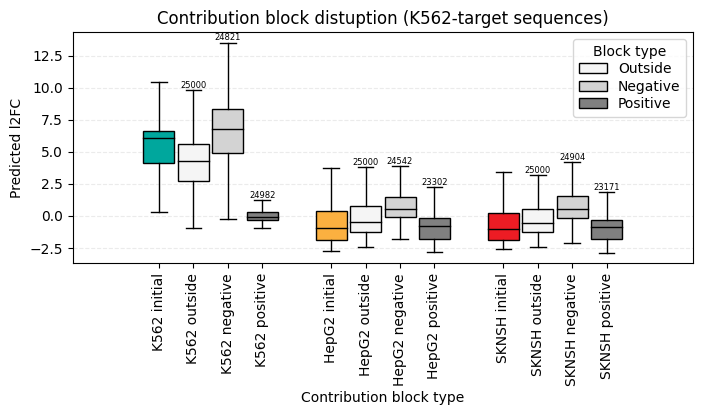

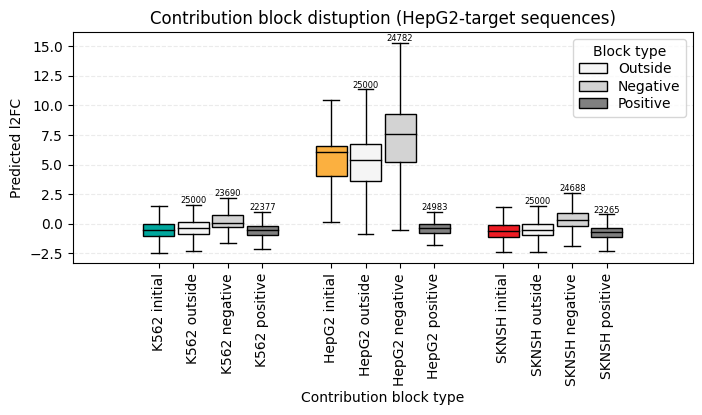

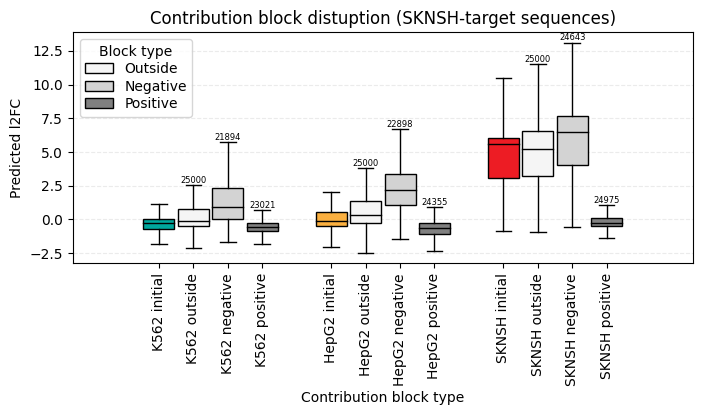

In [11]:
n_text_size = 6
n_text_color = 'black'
n_text_pad =  1.5
n_text_quartile = 75
figsize = (8, 3)

from matplotlib.patches import Patch

for group_cell_idx in range(3):
    group_disrupt_dict = all_group_disrupt_dicts[group_cell_idx]

    original_pred_dists = [group_disrupt_dict['original_preds'][:, i].tolist() for i in range(3)]
    pos_disrupted_dists = []
    neg_disrupted_dists = []
    neutral_disrupted_dists = []
    for cell_idx, cell_type in enumerate(cell_types):
        #---- Positive disruption ---
        disrupted_sizes = np.array(group_disrupt_dict[cell_type]['pos_block_ablation']['coverage_sizes'])
        disrupted_preds = group_disrupt_dict[cell_type]['pos_block_ablation']['disrupted_preds']

        actually_disrupted_seq_idxs = np.where(disrupted_sizes > 0)[0]
        pos_disrupted_dists.append(disrupted_preds[actually_disrupted_seq_idxs, ...][:, cell_idx].tolist())

        #---- Negative disruption ---
        disrupted_sizes = np.array(group_disrupt_dict[cell_type]['neg_block_ablation']['coverage_sizes'])
        disrupted_preds = group_disrupt_dict[cell_type]['neg_block_ablation']['disrupted_preds']

        actually_disrupted_seq_idxs = np.where(disrupted_sizes > 0)[0]
        neg_disrupted_dists.append(disrupted_preds[actually_disrupted_seq_idxs, ...][:, cell_idx].tolist())

        #---- Neutral disruption ---
        disrupted_sizes = np.array(group_disrupt_dict[cell_type]['neutral_block_ablation']['coverage_sizes'])
        disrupted_preds = group_disrupt_dict[cell_type]['neutral_block_ablation']['disrupted_preds']

        actually_disrupted_seq_idxs = np.where(disrupted_sizes > 0)[0]
        neutral_disrupted_dists.append(disrupted_preds[actually_disrupted_seq_idxs, ...][:, cell_idx].tolist())

    fig = plt.figure(figsize=figsize)


    #plt.hlines(0, 0, 4, linestyles='--', zorder=0, color='black', alpha=0.1, linewidth=2)
    boxplot = plt.boxplot(original_pred_dists, positions=[0.6, 1.6, 2.6] , widths=0.18, showfliers=False,
                            labels=[f'{cell_type} initial' for cell_type in cell_types], patch_artist=True, zorder=1)
    boxplot_05 = plt.boxplot(neutral_disrupted_dists, positions=[0.8, 1.8, 2.8] , widths=0.18, showfliers=False,
                            labels=[f'{cell_type} outside' for cell_type in cell_types], patch_artist=True, zorder=1)
    boxplot_2 = plt.boxplot(neg_disrupted_dists, positions=[1., 2., 3.] , widths=0.18, showfliers=False,
                            labels=[f'{cell_type} negative' for cell_type in cell_types], patch_artist=True, zorder=1)
    boxplot_3 = plt.boxplot(pos_disrupted_dists, positions=[1.2, 2.2, 3.2] , widths=0.18, showfliers=False,
                            labels=[f'{cell_type} positive' for cell_type in cell_types], patch_artist=True, zorder=1)
    # Set fill colors for each box
    for box, color in zip(boxplot['boxes'], cell_colors):
        box.set(facecolor=color, alpha=1)
    for median in boxplot['medians']:
        median.set(color='black')

    for box_i, (box, color) in enumerate(zip(boxplot_05['boxes'], cell_colors)):
        box.set(facecolor='whitesmoke', alpha=1)
        dist = neutral_disrupted_dists[box_i]
        box_x = 0.8 + box_i
        num_points = len(dist) #int(np.round(100 * len(dist) / group_size, 0))
        max_point = np.percentile(dist, n_text_quartile) + n_text_pad * stats.iqr(dist)
        plt.text(box_x, max_point, f'{num_points}',
             ha='center', va='bottom', color=n_text_color, fontsize=n_text_size)
    for median in boxplot_05['medians']:
        median.set(color='black')

    for box_i, (box, color) in enumerate(zip(boxplot_2['boxes'], cell_colors)):
        box.set(facecolor='lightgrey', alpha=1)
        dist = neg_disrupted_dists[box_i]
        box_x = 1 + box_i
        num_points = len(dist) #int(np.round(100 * len(dist) / group_size, 0))
        max_point = np.percentile(dist, n_text_quartile) + n_text_pad * stats.iqr(dist)
        plt.text(box_x, max_point, f'{num_points}',
             ha='center', va='bottom', color=n_text_color, fontsize=n_text_size)
    for median in boxplot_2['medians']:
        median.set(color='black')

    for box_i, (box, color) in enumerate(zip(boxplot_3['boxes'], cell_colors)):
        box.set(facecolor='grey', alpha=1)
        dist = pos_disrupted_dists[box_i]
        box_x = 1.2 + box_i
        num_points = len(dist) #int(np.round(100 * len(dist) / group_size, 0))
        max_point = np.percentile(dist, n_text_quartile) + n_text_pad * stats.iqr(dist)
        plt.text(box_x, max_point, f'{num_points}',
             ha='center', va='bottom', color=n_text_color, fontsize=n_text_size)
    for median in boxplot_3['medians']:
        median.set(color='black')

    # for i in range(3):
    #     plt.hlines(np.median(original_pred_dists[i]), 0.45 + i, 1.35 + i, \
    #            linestyles='-', zorder=0, color=cell_colors[i], alpha=0.75, linewidth=1.75)

    plt.ylabel('Predicted l2FC')
    plt.xlabel('Contribution block type')
    plt.xticks(rotation=90)
    disrupted_pct = np.sum(coverage_sizes) / (200 * len(coverage_sizes))
    plt.title(f'Contribution block distuption ({cell_types[group_cell_idx]}-target sequences)')

    ax = fig.gca()
    ax.grid(axis='y', linestyle = "dashed", alpha=0.25)
    ax.set_axisbelow(True)

    custom_lines = [Patch(facecolor='whitesmoke', edgecolor='black', label='Color Patch'),
                Patch(facecolor='lightgrey', edgecolor='black', label='Color Patch'),
                Patch(facecolor='grey', edgecolor='black', label='Color Patch'),]
    ax.legend(custom_lines, ['Outside', 'Negative', 'Positive'], title='Block type', labelspacing=0.25, fontsize=10)
    plt.savefig(f"/content/drive/MyDrive/figures/contribution_block_ablation_l2FC_{cell_types[group_cell_idx]}.pdf", bbox_inches = 'tight', pad_inches=0, dpi=200)
    plt.show()

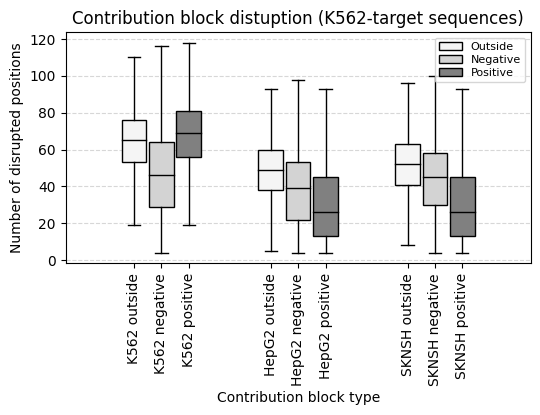

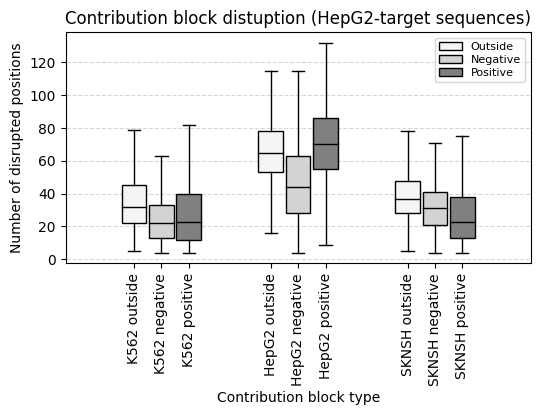

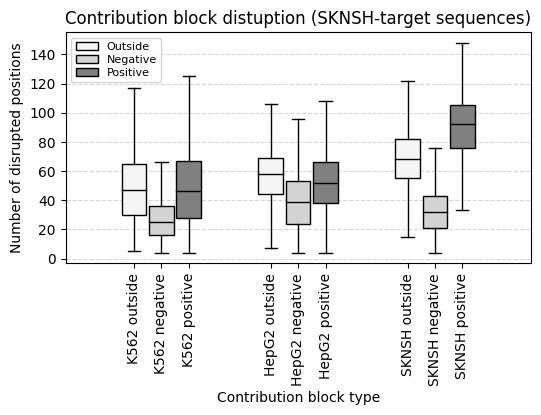

In [12]:
figsize = (6, 3)

for group_cell_idx in range(3):
    group_disrupt_dict = all_group_disrupt_dicts[group_cell_idx]

    original_pred_dists = [group_disrupt_dict['original_preds'][:, i].tolist() for i in range(3)]
    pos_disrupted_dists = []
    neg_disrupted_dists = []
    neutral_disrupted_dists = []
    for cell_idx, cell_type in enumerate(cell_types):
        #---- Positive disruption ---
        disrupted_sizes = np.array(group_disrupt_dict[cell_type]['pos_block_ablation']['coverage_sizes'])
        disrupted_preds = group_disrupt_dict[cell_type]['pos_block_ablation']['disrupted_preds']

        actually_disrupted_seq_idxs = np.where(disrupted_sizes > 0)[0]
        pos_disrupted_dists.append(disrupted_sizes[actually_disrupted_seq_idxs, ...].tolist())

        #---- Negative disruption ---
        disrupted_sizes = np.array(group_disrupt_dict[cell_type]['neg_block_ablation']['coverage_sizes'])
        disrupted_preds = group_disrupt_dict[cell_type]['neg_block_ablation']['disrupted_preds']

        actually_disrupted_seq_idxs = np.where(disrupted_sizes > 0)[0]
        neg_disrupted_dists.append(disrupted_sizes[actually_disrupted_seq_idxs, ...].tolist())

        #---- Neutral disruption ---
        disrupted_sizes = np.array(group_disrupt_dict[cell_type]['neutral_block_ablation']['coverage_sizes'])
        disrupted_preds = group_disrupt_dict[cell_type]['neutral_block_ablation']['disrupted_preds']

        actually_disrupted_seq_idxs = np.where(disrupted_sizes > 0)[0]
        neutral_disrupted_dists.append(disrupted_sizes[actually_disrupted_seq_idxs, ...].tolist())

    fig = plt.figure(figsize=figsize)
    #plt.hlines(0, 0.5, 3.5, linestyles='--', zorder=0, color='black', alpha=0.1, linewidth=2)
    # boxplot = plt.boxplot(original_pred_dists, positions=[0.6, 1.6, 2.6] , widths=0.18, showfliers=False,
    #                         labels=[f'Original' for cell_type in cell_types], patch_artist=True, zorder=1)
    boxplot_05 = plt.boxplot(neutral_disrupted_dists, positions=[0.8, 1.8, 2.8] , widths=0.18, showfliers=False,
                            labels=[f'{cell_type} outside' for cell_type in cell_types], patch_artist=True, zorder=1)
    boxplot_2 = plt.boxplot(neg_disrupted_dists, positions=[1., 2., 3.] , widths=0.18, showfliers=False,
                            labels=[f'{cell_type} negative' for cell_type in cell_types], patch_artist=True, zorder=1)
    boxplot_3 = plt.boxplot(pos_disrupted_dists, positions=[1.2, 2.2, 3.2] , widths=0.18, showfliers=False,
                            labels=[f'{cell_type} positive' for cell_type in cell_types], patch_artist=True, zorder=1)
    # Set fill colors for each box
    for box, color in zip(boxplot['boxes'], cell_colors):
        box.set(facecolor=color, alpha=1)
    for median in boxplot['medians']:
        median.set(color='black')

    for box, color in zip(boxplot_05['boxes'], cell_colors):
        box.set(facecolor='whitesmoke', alpha=1)
    for median in boxplot_05['medians']:
        median.set(color='black')

    for box, color in zip(boxplot_2['boxes'], cell_colors):
        box.set(facecolor='lightgrey', alpha=1)
    for median in boxplot_2['medians']:
        median.set(color='black')

    for box, color in zip(boxplot_3['boxes'], cell_colors):
        box.set(facecolor='grey', alpha=1)
    for median in boxplot_3['medians']:
        median.set(color='black')

    # for i in range(3):
    #     plt.hlines(np.median(original_pred_dists[i]), 0.45 + i, 1.35 + i, \
    #            linestyles='-', zorder=0, color=cell_colors[i], alpha=0.75, linewidth=1.75)

    plt.ylabel('Number of disrupted positions')
    plt.xlabel('Contribution block type')
    plt.xticks(rotation=90)
    disrupted_pct = np.sum(coverage_sizes) / (200 * len(coverage_sizes))
    plt.title(f'Contribution block distuption ({cell_types[group_cell_idx]}-target sequences)')

    ax = fig.gca()
    ax.grid(axis='y', linestyle = "dashed", alpha=0.5)
    ax.set_axisbelow(True)

    custom_lines = [Patch(facecolor='whitesmoke', edgecolor='black', label='Color Patch'),
                Patch(facecolor='lightgrey', edgecolor='black', label='Color Patch'),
                Patch(facecolor='grey', edgecolor='black', label='Color Patch'),]
    ax.legend(custom_lines, ['Outside', 'Negative', 'Positive'], labelspacing=0.25, fontsize=8)
    #plt.ylim(0, 150)
    plt.savefig(f"/content/drive/MyDrive/figures/contribution_block_ablation_coverage_{cell_types[group_cell_idx]}.pdf", bbox_inches = 'tight', pad_inches=0, dpi=200)
    plt.show()

#Load contribution-block disruption and subsample

In [ ]:
from tqdm import trange
from statsmodels.stats.multicomp import pairwise_tukeyhsd

all_group_disrupt_dicts = torch.load('/content/drive/MyDrive/data/BODA2_MPRA/CODA_contributions/contribution_block_ablation_v4.pt')

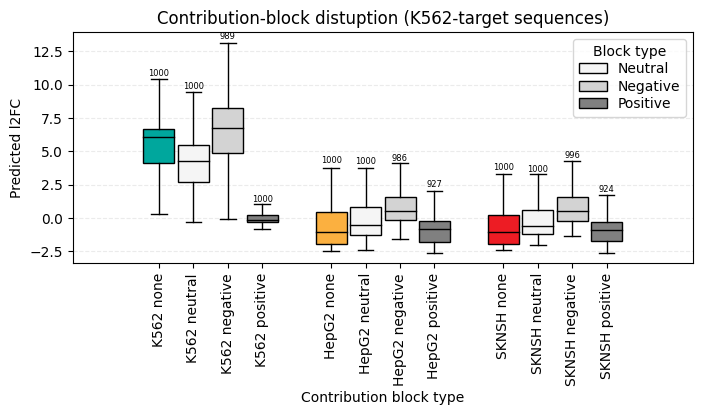

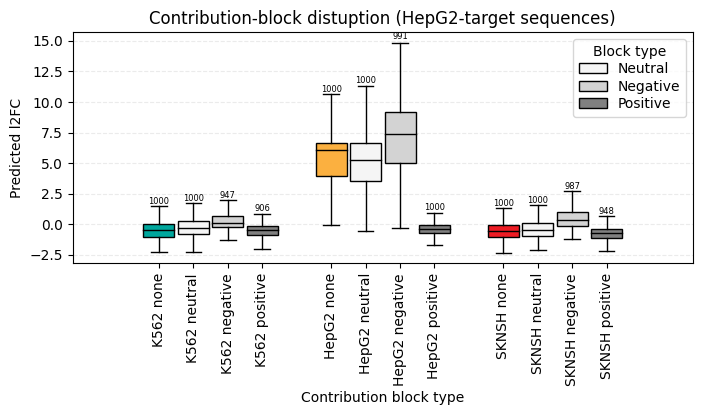

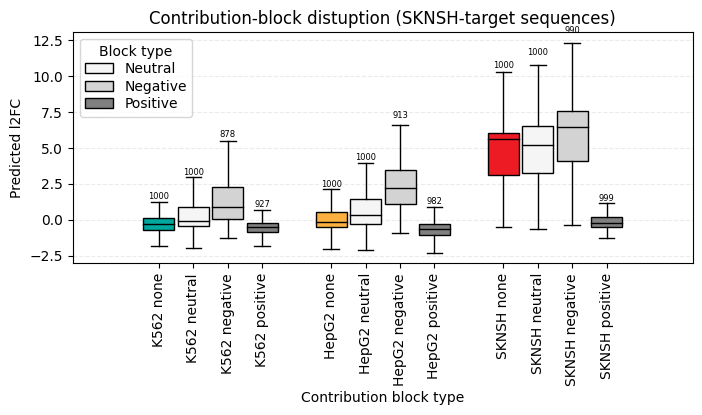

In [ ]:
sample_n = 1000

n_text_size = 6
n_text_color = 'black'
n_text_pad =  1.5
n_text_quartile = 75
n_text_y_max = 15
n_text_fontweight = 'normal'
figsize = (8, 3)

from matplotlib.patches import Patch

for group_cell_idx in range(3):
    group_disrupt_dict = all_group_disrupt_dicts[group_cell_idx]
    subsampled_idxs = random.sample(range(25000), sample_n)

    original_pred_dists = [group_disrupt_dict['original_preds'][subsampled_idxs, i].tolist() for i in range(3)]

    pos_disrupted_dists = []
    neg_disrupted_dists = []
    neutral_disrupted_dists = []
    for cell_idx, cell_type in enumerate(cell_types):
        #---- Positive disruption ---
        disrupted_sizes = np.array(group_disrupt_dict[cell_type]['pos_block_ablation']['coverage_sizes'])
        disrupted_preds = group_disrupt_dict[cell_type]['pos_block_ablation']['disrupted_preds']

        actually_disrupted_seq_idxs = np.where(disrupted_sizes > 0)[0]
        actually_disrupted_seq_idxs = np.intersect1d(actually_disrupted_seq_idxs, subsampled_idxs)
        pos_disrupted_dists.append(disrupted_preds[actually_disrupted_seq_idxs, ...][:, cell_idx].tolist())

        #---- Negative disruption ---
        disrupted_sizes = np.array(group_disrupt_dict[cell_type]['neg_block_ablation']['coverage_sizes'])
        disrupted_preds = group_disrupt_dict[cell_type]['neg_block_ablation']['disrupted_preds']

        actually_disrupted_seq_idxs = np.where(disrupted_sizes > 0)[0]
        actually_disrupted_seq_idxs = np.intersect1d(actually_disrupted_seq_idxs, subsampled_idxs)
        neg_disrupted_dists.append(disrupted_preds[actually_disrupted_seq_idxs, ...][:, cell_idx].tolist())

        #---- Neutral disruption ---
        disrupted_sizes = np.array(group_disrupt_dict[cell_type]['neutral_block_ablation']['coverage_sizes'])
        disrupted_preds = group_disrupt_dict[cell_type]['neutral_block_ablation']['disrupted_preds']

        actually_disrupted_seq_idxs = np.where(disrupted_sizes > 0)[0]
        actually_disrupted_seq_idxs = np.intersect1d(actually_disrupted_seq_idxs, subsampled_idxs)
        neutral_disrupted_dists.append(disrupted_preds[actually_disrupted_seq_idxs, ...][:, cell_idx].tolist())

    fig = plt.figure(figsize=figsize)

    #plt.hlines(0, 0, 4, linestyles='--', zorder=0, color='black', alpha=0.1, linewidth=2)
    boxplot = plt.boxplot(original_pred_dists, positions=[0.6, 1.6, 2.6] , widths=0.18, showfliers=False,
                            labels=[f'{cell_type} none' for cell_type in cell_types], patch_artist=True, zorder=1)
    boxplot_05 = plt.boxplot(neutral_disrupted_dists, positions=[0.8, 1.8, 2.8] , widths=0.18, showfliers=False,
                            labels=[f'{cell_type} neutral' for cell_type in cell_types], patch_artist=True, zorder=1)
    boxplot_2 = plt.boxplot(neg_disrupted_dists, positions=[1., 2., 3.] , widths=0.18, showfliers=False,
                            labels=[f'{cell_type} negative' for cell_type in cell_types], patch_artist=True, zorder=1)
    boxplot_3 = plt.boxplot(pos_disrupted_dists, positions=[1.2, 2.2, 3.2] , widths=0.18, showfliers=False,
                            labels=[f'{cell_type} positive' for cell_type in cell_types], patch_artist=True, zorder=1)
    # Set fill colors for each box
    for box_i, (box, color) in enumerate(zip(boxplot['boxes'], cell_colors)):
        box.set(facecolor=color, alpha=1)
        dist = original_pred_dists[box_i]
        box_x = 0.6 + box_i
        num_points = len(dist) #int(np.round(100 * len(dist) / sample_n, 0))
        max_point = min(n_text_y_max, np.percentile(dist, n_text_quartile) + n_text_pad * stats.iqr(dist))
        plt.text(box_x, max_point, f'{num_points}',
             ha='center', va='bottom', color=n_text_color, fontsize=n_text_size, fontweight=n_text_fontweight)
    for median in boxplot['medians']:
        median.set(color='black')

    for box_i, (box, color) in enumerate(zip(boxplot_05['boxes'], cell_colors)):
        box.set(facecolor='whitesmoke', alpha=1)
        dist = neutral_disrupted_dists[box_i]
        box_x = 0.8 + box_i
        num_points = len(dist) #int(np.round(100 * len(dist) / sample_n, 0))
        max_point = min(n_text_y_max, np.percentile(dist, n_text_quartile) + n_text_pad * stats.iqr(dist))
        plt.text(box_x, max_point, f'{num_points}',
             ha='center', va='bottom', color=n_text_color, fontsize=n_text_size, fontweight=n_text_fontweight)
    for median in boxplot_05['medians']:
        median.set(color='black')

    for box_i, (box, color) in enumerate(zip(boxplot_2['boxes'], cell_colors)):
        box.set(facecolor='lightgrey', alpha=1)
        dist = neg_disrupted_dists[box_i]
        box_x = 1 + box_i
        num_points = len(dist) #int(np.round(100 * len(dist) / sample_n, 0))
        max_point = min(n_text_y_max, np.percentile(dist, n_text_quartile) + n_text_pad * stats.iqr(dist))
        plt.text(box_x, max_point, f'{num_points}',
             ha='center', va='bottom', color=n_text_color, fontsize=n_text_size, fontweight=n_text_fontweight)
    for median in boxplot_2['medians']:
        median.set(color='black')

    for box_i, (box, color) in enumerate(zip(boxplot_3['boxes'], cell_colors)):
        box.set(facecolor='grey', alpha=1)
        dist = pos_disrupted_dists[box_i]
        box_x = 1.2 + box_i
        num_points = len(dist) #int(np.round(100 * len(dist) / sample_n, 0))
        max_point = min(n_text_y_max, np.percentile(dist, n_text_quartile) + n_text_pad * stats.iqr(dist))
        plt.text(box_x, max_point, f'{num_points}',
             ha='center', va='bottom', color=n_text_color, fontsize=n_text_size, fontweight=n_text_fontweight)
    for median in boxplot_3['medians']:
        median.set(color='black')

    # for i in range(3):
    #     plt.hlines(np.median(original_pred_dists[i]), 0.45 + i, 1.35 + i, \
    #            linestyles='-', zorder=0, color=cell_colors[i], alpha=0.75, linewidth=1.75)

    plt.ylabel('Predicted l2FC')
    plt.xlabel('Contribution block type')
    plt.xticks(rotation=90)
    #disrupted_pct = np.sum(coverage_sizes) / (200 * len(coverage_sizes))
    plt.title(f'Contribution-block distuption ({cell_types[group_cell_idx]}-target sequences)')

    ax = fig.gca()
    ax.grid(axis='y', linestyle = "dashed", alpha=0.25)
    ax.set_axisbelow(True)

    custom_lines = [Patch(facecolor='whitesmoke', edgecolor='black', label='Color Patch'),
                Patch(facecolor='lightgrey', edgecolor='black', label='Color Patch'),
                Patch(facecolor='grey', edgecolor='black', label='Color Patch'),]
    ax.legend(custom_lines, ['Neutral', 'Negative', 'Positive'], title='Block type', labelspacing=0.25, fontsize=10)

    plt.show()

100%|██████████| 20/20 [32:08<00:00, 96.42s/it] 


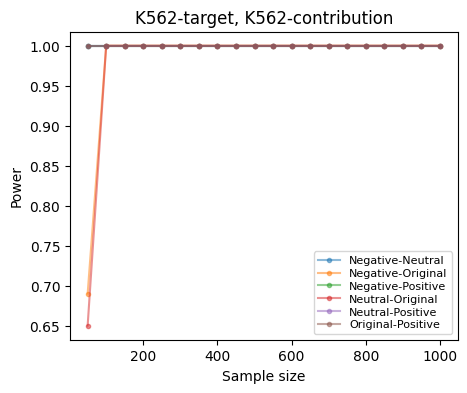

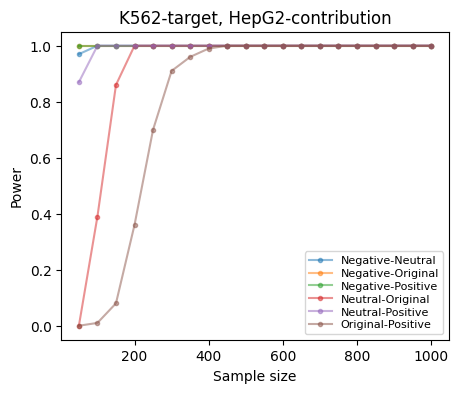

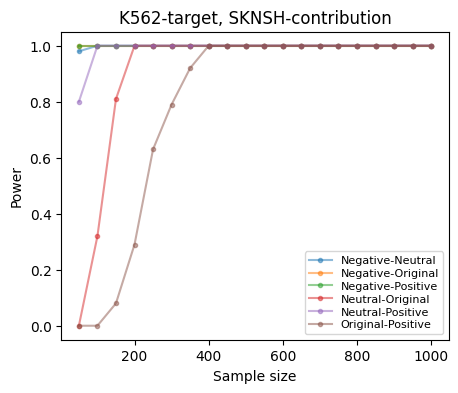

100%|██████████| 20/20 [30:28<00:00, 91.45s/it]


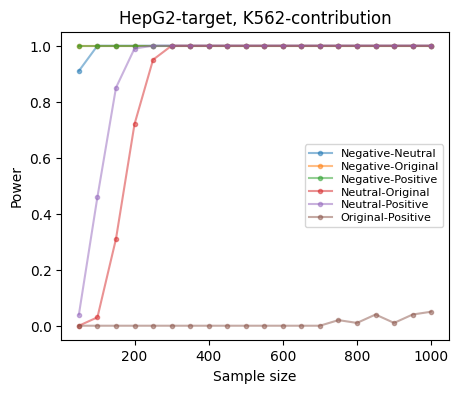

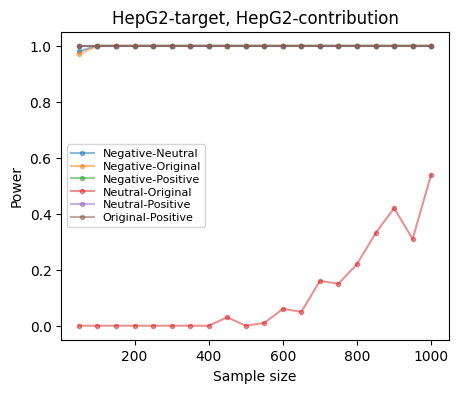

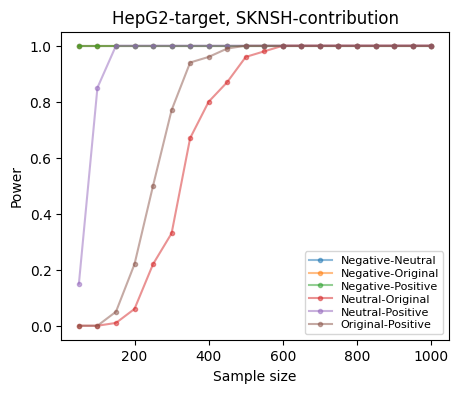

100%|██████████| 20/20 [30:57<00:00, 92.87s/it]


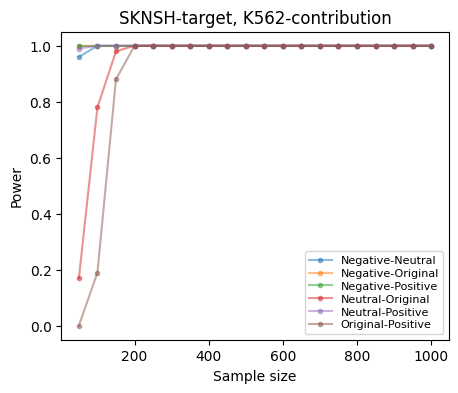

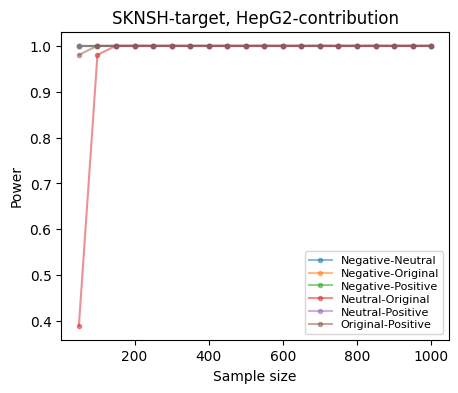

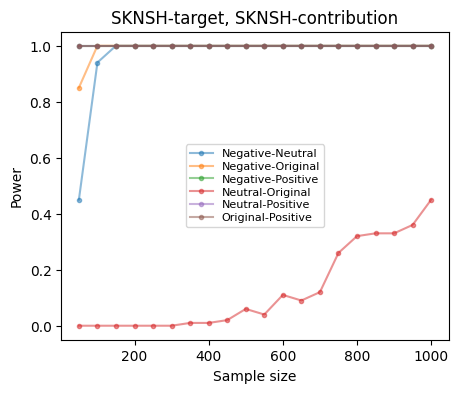

In [ ]:
max_sample_n = 1050
step_sample_n = 50
n_trials = 100

group_names = ['Original', 'Positive', 'Negative', 'Neutral']

all_reject_points = []
for group_cell_idx in range(3):
    reject_points = []
    for sample_n in trange(step_sample_n, max_sample_n, step_sample_n):
        all_rejects = []
        for n_trial in range(n_trials):
            group_disrupt_dict = all_group_disrupt_dicts[group_cell_idx]
            subsampled_idxs = random.sample(range(25000), sample_n)

            original_pred_dists = [group_disrupt_dict['original_preds'][subsampled_idxs, i].tolist() for i in range(3)]

            pos_disrupted_dists = []
            neg_disrupted_dists = []
            neutral_disrupted_dists = []
            for cell_idx, cell_type in enumerate(cell_types):
                #---- Positive disruption ---
                disrupted_sizes = np.array(group_disrupt_dict[cell_type]['pos_block_ablation']['coverage_sizes'])
                disrupted_preds = group_disrupt_dict[cell_type]['pos_block_ablation']['disrupted_preds']

                actually_disrupted_seq_idxs = np.where(disrupted_sizes > 0)[0]
                actually_disrupted_seq_idxs = np.intersect1d(actually_disrupted_seq_idxs, subsampled_idxs)
                pos_disrupted_dists.append(disrupted_preds[actually_disrupted_seq_idxs, ...][:, cell_idx].tolist())

                #---- Negative disruption ---
                disrupted_sizes = np.array(group_disrupt_dict[cell_type]['neg_block_ablation']['coverage_sizes'])
                disrupted_preds = group_disrupt_dict[cell_type]['neg_block_ablation']['disrupted_preds']

                actually_disrupted_seq_idxs = np.where(disrupted_sizes > 0)[0]
                actually_disrupted_seq_idxs = np.intersect1d(actually_disrupted_seq_idxs, subsampled_idxs)
                neg_disrupted_dists.append(disrupted_preds[actually_disrupted_seq_idxs, ...][:, cell_idx].tolist())

                #---- Neutral disruption ---
                disrupted_sizes = np.array(group_disrupt_dict[cell_type]['neutral_block_ablation']['coverage_sizes'])
                disrupted_preds = group_disrupt_dict[cell_type]['neutral_block_ablation']['disrupted_preds']

                actually_disrupted_seq_idxs = np.where(disrupted_sizes > 0)[0]
                actually_disrupted_seq_idxs = np.intersect1d(actually_disrupted_seq_idxs, subsampled_idxs)
                neutral_disrupted_dists.append(disrupted_preds[actually_disrupted_seq_idxs, ...][:, cell_idx].tolist())

            all_dists = [original_pred_dists, pos_disrupted_dists, neg_disrupted_dists, neutral_disrupted_dists]

            rejects = []
            for contrib_cell_idx in range(3):
                data = [dist[contrib_cell_idx] for dist in all_dists]

                df = pd.DataFrame({
                    'group': np.repeat(group_names, [len(x) for x in data]),
                    'value': np.concatenate(data)
                })

                posthoc = pairwise_tukeyhsd(df['value'], df['group'])

                rejects.append(1 * posthoc.reject)

            all_rejects.append(np.stack(rejects))

        reject_points.append(np.stack(all_rejects, axis=-1))
    all_reject_points.append(reject_points)
    pair_names = [x[0] + '-' + x[1] for x in posthoc._results_table.data[1:]]

    for cell_idx, cell_type in enumerate(cell_types):
        fig = plt.figure(figsize=(5,4))
        x = list(range(step_sample_n, max_sample_n, step_sample_n))
        for pair_idx, pair_name in enumerate(pair_names):
            y = [x[cell_idx][pair_idx, :].mean() for x in reject_points]
            plt.plot(x, y, linestyle='-', marker='.', label=pair_name, alpha=0.5)
            #print(f'{pair_name}: {y}')
        plt.legend(labelspacing=0.25, fontsize=8)
        plt.xlabel('Sample size')
        plt.ylabel('Power')
        plt.title(f'{cell_types[group_cell_idx]}-target, {cell_type}-contribution')
        plt.show()

save_path = f'/content/drive/MyDrive/data/BODA2_MPRA/contribution_block_power_{n_trials}trials_{max_sample_n - step_sample_n}samples_v4.pt'
torch.save(all_reject_points, save_path)

100%|██████████| 20/20 [31:17<00:00, 93.89s/it]


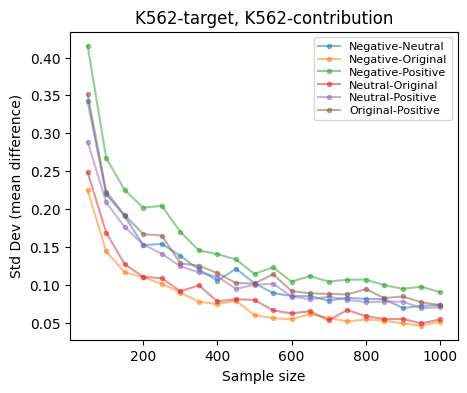

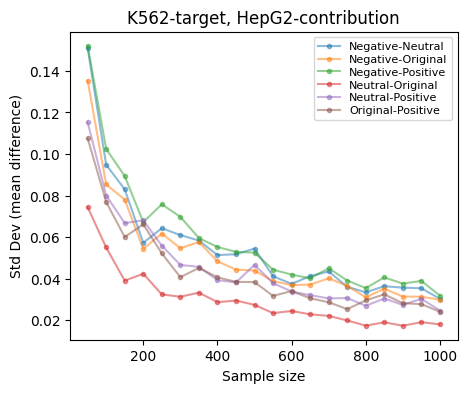

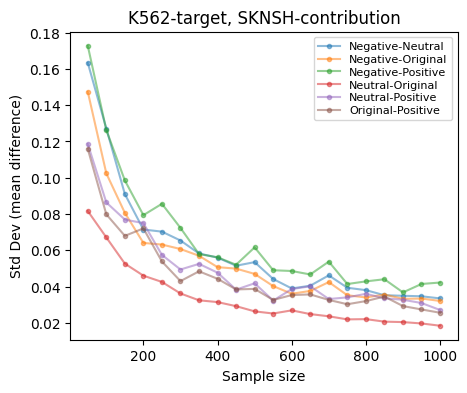

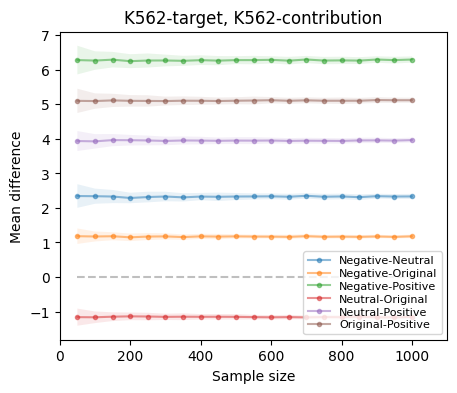

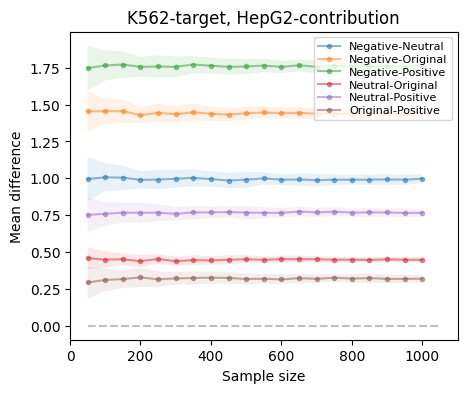

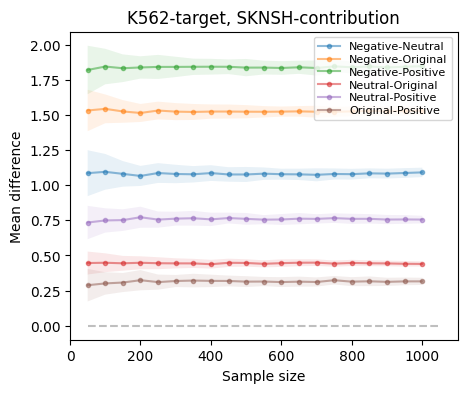

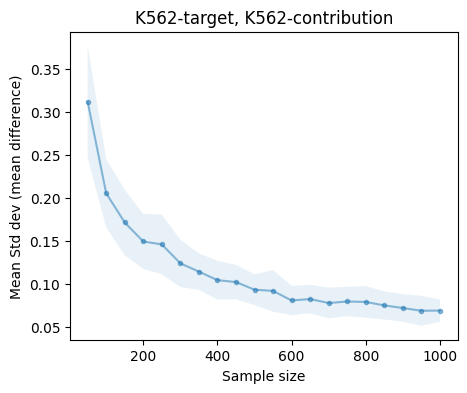

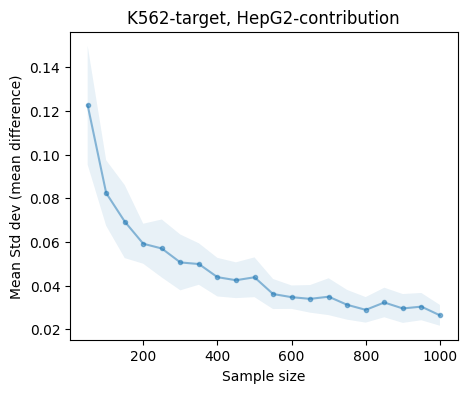

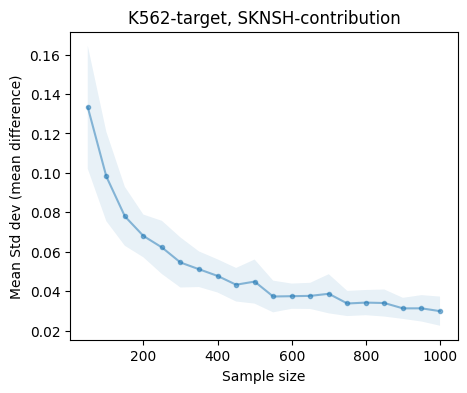

100%|██████████| 20/20 [31:12<00:00, 93.61s/it] 


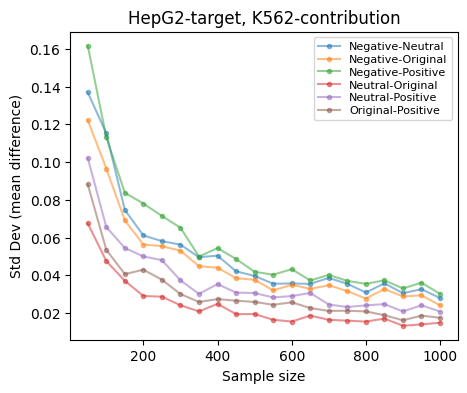

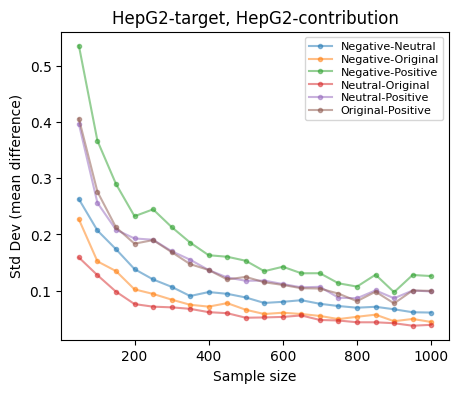

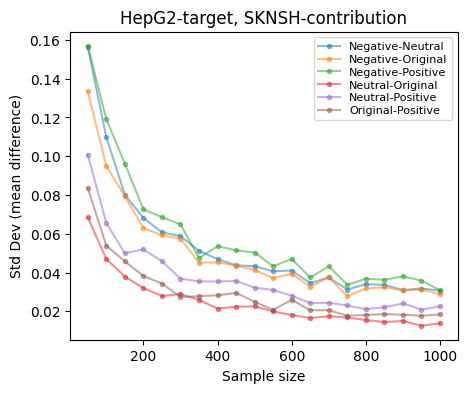

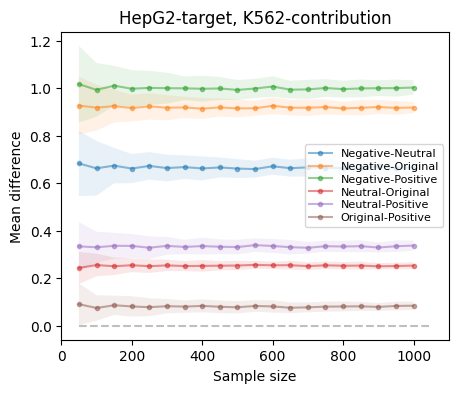

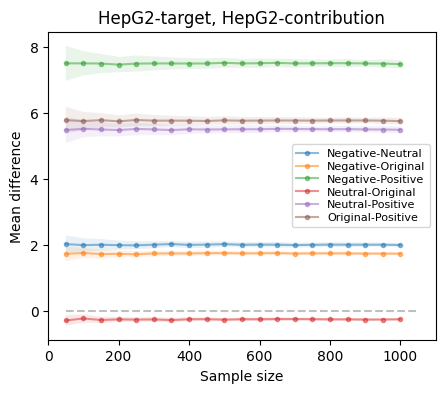

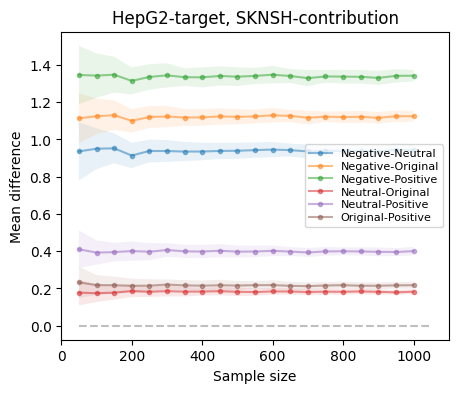

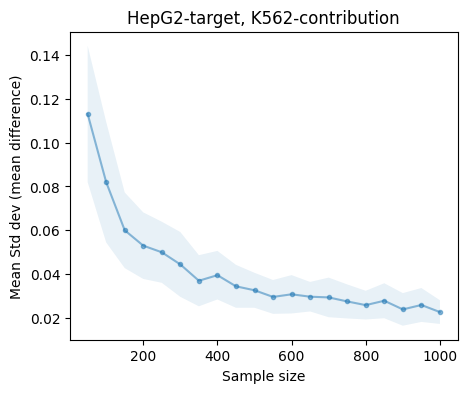

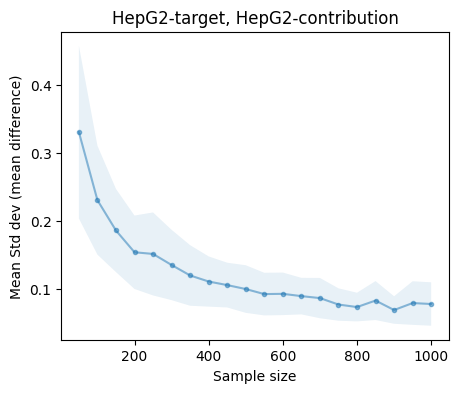

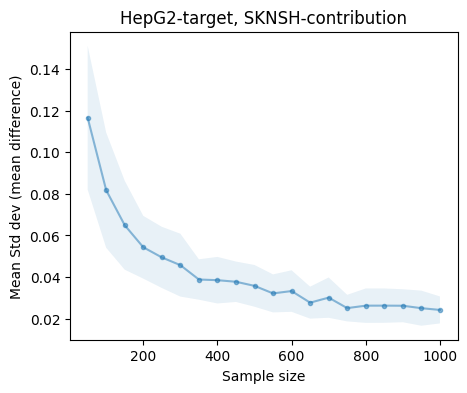

100%|██████████| 20/20 [31:47<00:00, 95.36s/it]


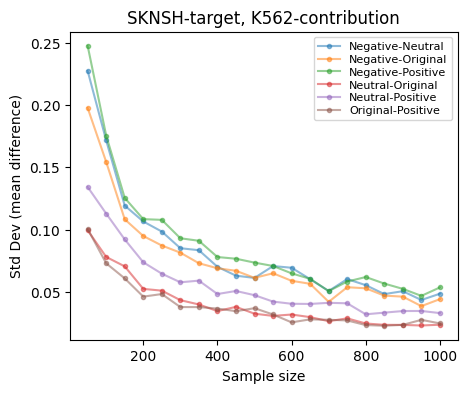

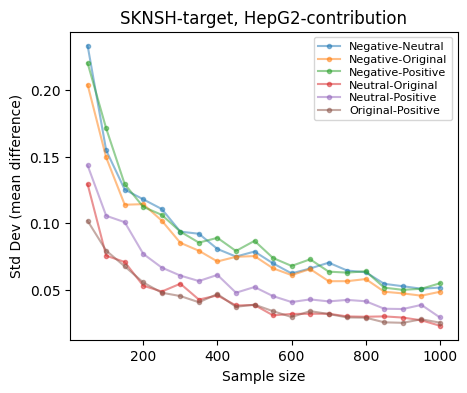

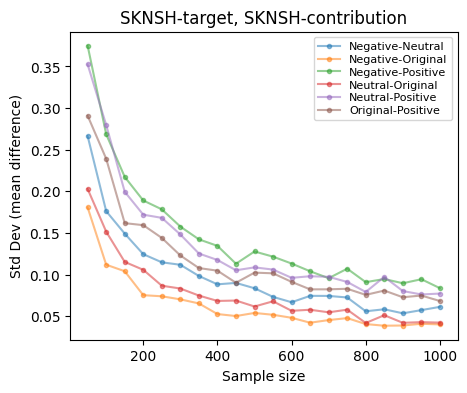

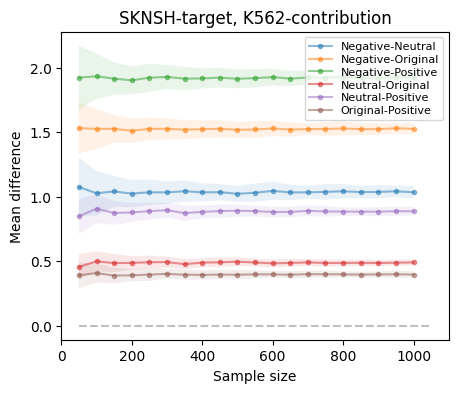

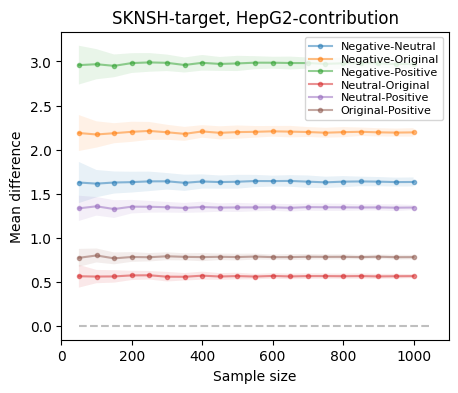

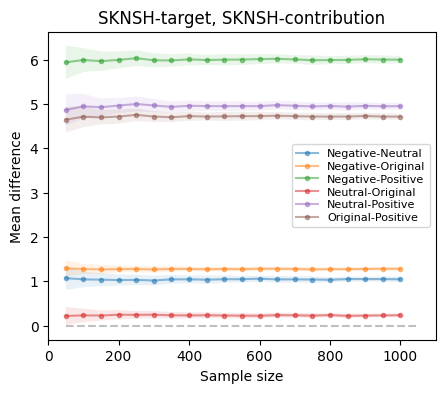

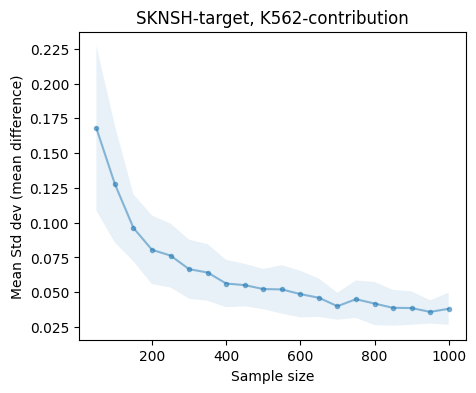

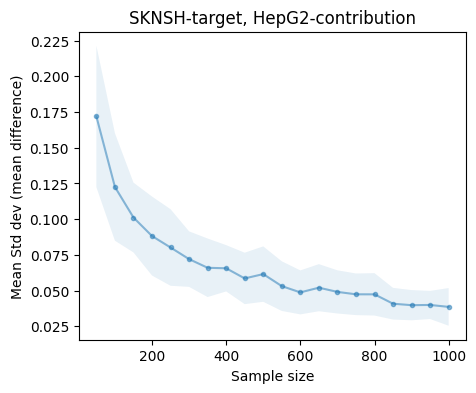

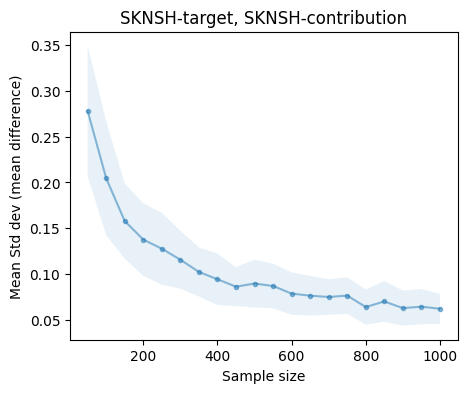

In [ ]:
max_sample_n = 1050
step_sample_n = 50
n_trials = 100

group_names = ['Original', 'Positive', 'Negative', 'Neutral']

all_meandiff_points = []
for group_cell_idx in range(3):
    meandiff_points = []
    for sample_n in trange(step_sample_n, max_sample_n, step_sample_n):
        all_meandiffs = []
        for n_trial in range(n_trials):
            group_disrupt_dict = all_group_disrupt_dicts[group_cell_idx]
            subsampled_idxs = random.sample(range(25000), sample_n)

            original_pred_dists = [group_disrupt_dict['original_preds'][subsampled_idxs, i].tolist() for i in range(3)]

            pos_disrupted_dists = []
            neg_disrupted_dists = []
            neutral_disrupted_dists = []
            for cell_idx, cell_type in enumerate(cell_types):
                #---- Positive disruption ---
                disrupted_sizes = np.array(group_disrupt_dict[cell_type]['pos_block_ablation']['coverage_sizes'])
                disrupted_preds = group_disrupt_dict[cell_type]['pos_block_ablation']['disrupted_preds']

                actually_disrupted_seq_idxs = np.where(disrupted_sizes > 0)[0]
                actually_disrupted_seq_idxs = np.intersect1d(actually_disrupted_seq_idxs, subsampled_idxs)
                pos_disrupted_dists.append(disrupted_preds[actually_disrupted_seq_idxs, ...][:, cell_idx].tolist())

                #---- Negative disruption ---
                disrupted_sizes = np.array(group_disrupt_dict[cell_type]['neg_block_ablation']['coverage_sizes'])
                disrupted_preds = group_disrupt_dict[cell_type]['neg_block_ablation']['disrupted_preds']

                actually_disrupted_seq_idxs = np.where(disrupted_sizes > 0)[0]
                actually_disrupted_seq_idxs = np.intersect1d(actually_disrupted_seq_idxs, subsampled_idxs)
                neg_disrupted_dists.append(disrupted_preds[actually_disrupted_seq_idxs, ...][:, cell_idx].tolist())

                #---- Neutral disruption ---
                disrupted_sizes = np.array(group_disrupt_dict[cell_type]['neutral_block_ablation']['coverage_sizes'])
                disrupted_preds = group_disrupt_dict[cell_type]['neutral_block_ablation']['disrupted_preds']

                actually_disrupted_seq_idxs = np.where(disrupted_sizes > 0)[0]
                actually_disrupted_seq_idxs = np.intersect1d(actually_disrupted_seq_idxs, subsampled_idxs)
                neutral_disrupted_dists.append(disrupted_preds[actually_disrupted_seq_idxs, ...][:, cell_idx].tolist())

            all_dists = [original_pred_dists, pos_disrupted_dists, neg_disrupted_dists, neutral_disrupted_dists]

            meandiffs = []
            for contrib_cell_idx in range(3):
                data = [dist[contrib_cell_idx] for dist in all_dists]

                df = pd.DataFrame({
                    'group': np.repeat(group_names, [len(x) for x in data]),
                    'value': np.concatenate(data)
                })

                posthoc = pairwise_tukeyhsd(df['value'], df['group'])

                meandiffs.append([x[2] for x in posthoc._results_table.data[1:]])

            all_meandiffs.append(np.stack(meandiffs))

        meandiff_points.append(np.stack(all_meandiffs, axis=-1))
    all_meandiff_points.append(meandiff_points)
    pair_names = [x[0] + '-' + x[1] for x in posthoc._results_table.data[1:]]

    for cell_idx, cell_type in enumerate(cell_types):
        fig = plt.figure(figsize=(5,4))
        x = list(range(step_sample_n, max_sample_n, step_sample_n))
        for pair_idx, pair_name in enumerate(pair_names):
            y = [x[cell_idx][pair_idx, :].std() for x in meandiff_points]
            plt.plot(x, y, linestyle='-', marker='.', label=pair_name, alpha=0.5)
        plt.legend(labelspacing=0.25, fontsize=8)
        plt.xlabel('Sample size')
        plt.ylabel('Std Dev (mean difference)')
        plt.title(f'{cell_types[group_cell_idx]}-target, {cell_type}-contribution')
        plt.show()

    for cell_idx, cell_type in enumerate(cell_types):
        fig = plt.figure(figsize=(5,4))
        plt.hlines(0, step_sample_n, max_sample_n, linestyles='dashed', alpha=0.5, color='grey')
        x = list(range(step_sample_n, max_sample_n, step_sample_n))
        for pair_idx, pair_name in enumerate(pair_names):
            y = [-x[cell_idx][pair_idx, :].mean() for x in meandiff_points]
            #plt.plot(x, y, linestyle='-', marker='.', label=pair_name, alpha=0.5)
            stdevs = np.array([np.std(x[cell_idx][pair_idx, :]) for x in meandiff_points])
            plt.plot(x, y, linestyle='-', marker='.', label=pair_name, alpha=0.5)
            plt.fill_between(x, y - stdevs, y + stdevs, alpha=0.1)
        plt.legend(labelspacing=0.25, fontsize=8)
        plt.xlabel('Sample size')
        plt.ylabel('Mean difference')
        plt.title(f'{cell_types[group_cell_idx]}-target, {cell_type}-contribution')
        plt.show()

    for cell_idx, cell_type in enumerate(cell_types):
        fig = plt.figure(figsize=(5,4))
        x = list(range(step_sample_n, max_sample_n, step_sample_n))
        global_y = []
        for pair_idx, pair_name in enumerate(pair_names):
            global_y.append([x[cell_idx][pair_idx, :].std() for x in meandiff_points])
        global_y = np.stack(global_y)
        global_y_means = global_y.mean(axis=0)
        global_y_stds = global_y.std(axis=0)
        plt.plot(x, global_y_means, linestyle='-', marker='.', label=pair_name, alpha=0.5)
        plt.fill_between(x, global_y_means - global_y_stds, global_y_means + global_y_stds, alpha=0.1)
        #plt.legend(labelspacing=0.25, fontsize=8)
        plt.xlabel('Sample size')
        plt.ylabel('Mean Std dev (mean difference)')
        plt.title(f'{cell_types[group_cell_idx]}-target, {cell_type}-contribution')
        plt.show()

    print()

save_path = f'/content/drive/MyDrive/data/BODA2_MPRA/contribution_block_meandiffs_{n_trials}trials_{max_sample_n - step_sample_n}samples_v4.pt'
torch.save(all_meandiff_points, save_path)

#Calculate expected library size

In [ ]:
from tqdm import trange

all_group_disrupt_dicts = torch.load('/content/drive/MyDrive/data/BODA2_MPRA/CODA_contributions/contribution_block_ablation_v4.pt')

In [ ]:
max_sample_n = 1050
step_sample_n = 50
n_trials = 100

group_names = ['Original', 'Positive', 'Negative', 'Neutral']

cell_sizes = []
for group_cell_idx in range(3):
    sample_sizes = []
    for sample_n in trange(step_sample_n, max_sample_n, step_sample_n):
        trial_sizes = []
        for n_trial in range(n_trials):
            group_disrupt_dict = all_group_disrupt_dicts[group_cell_idx]
            subsampled_idxs = random.sample(range(25000), sample_n)

            original_pred_dists = [group_disrupt_dict['original_preds'][subsampled_idxs, i].tolist() for i in range(3)]

            pos_disrupted_dists = []
            neg_disrupted_dists = []
            neutral_disrupted_dists = []
            for cell_idx, cell_type in enumerate(cell_types):
                #---- Positive disruption ---
                disrupted_sizes = np.array(group_disrupt_dict[cell_type]['pos_block_ablation']['coverage_sizes'])
                disrupted_preds = group_disrupt_dict[cell_type]['pos_block_ablation']['disrupted_preds']

                actually_disrupted_seq_idxs = np.where(disrupted_sizes > 0)[0]
                actually_disrupted_seq_idxs = np.intersect1d(actually_disrupted_seq_idxs, subsampled_idxs)
                pos_disrupted_dists.append(disrupted_preds[actually_disrupted_seq_idxs, ...][:, cell_idx].tolist())

                #---- Negative disruption ---
                disrupted_sizes = np.array(group_disrupt_dict[cell_type]['neg_block_ablation']['coverage_sizes'])
                disrupted_preds = group_disrupt_dict[cell_type]['neg_block_ablation']['disrupted_preds']

                actually_disrupted_seq_idxs = np.where(disrupted_sizes > 0)[0]
                actually_disrupted_seq_idxs = np.intersect1d(actually_disrupted_seq_idxs, subsampled_idxs)
                neg_disrupted_dists.append(disrupted_preds[actually_disrupted_seq_idxs, ...][:, cell_idx].tolist())

                #---- Neutral disruption ---
                disrupted_sizes = np.array(group_disrupt_dict[cell_type]['neutral_block_ablation']['coverage_sizes'])
                disrupted_preds = group_disrupt_dict[cell_type]['neutral_block_ablation']['disrupted_preds']

                actually_disrupted_seq_idxs = np.where(disrupted_sizes > 0)[0]
                actually_disrupted_seq_idxs = np.intersect1d(actually_disrupted_seq_idxs, subsampled_idxs)
                neutral_disrupted_dists.append(disrupted_preds[actually_disrupted_seq_idxs, ...][:, cell_idx].tolist())

            all_dists = [original_pred_dists, pos_disrupted_dists, neg_disrupted_dists, neutral_disrupted_dists]
            trial_sizes.append(np.sum([[len(x) for x in sublist] for sublist in all_dists[1:]]) + sample_n)    #I adjusted for double counting the original seqs
        sample_sizes.append(trial_sizes)
    cell_sizes.append(sample_sizes)

100%|██████████| 20/20 [00:48<00:00,  2.42s/it]


In [ ]:
median_sizes = []
all_sizes = []
for step_idx, sample_size in enumerate(range(step_sample_n, max_sample_n, step_sample_n)):
    sizes = [cell_sizes[cell_idx][step_idx] for cell_idx in range(3)]
    median_size = np.mean(sizes)
    all_sizes.append(sizes)
    median_sizes.append(median_size)

all_cells_sizes = [np.array(sizes).sum(axis=0) for sizes in all_sizes]

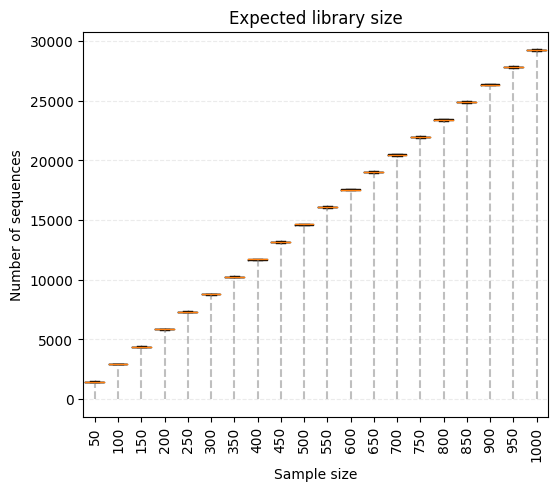

In [ ]:
fig = plt.figure(figsize=(6,5))
sample_ns = range(step_sample_n, max_sample_n, step_sample_n)
plt.boxplot(all_cells_sizes, widths=0.8, showfliers=False, labels=sample_ns)
for j, median_size in enumerate(median_sizes):
    plt.vlines(j +1, 0, 3*median_size, linestyles='dashed', alpha=0.5, color='grey')
plt.xticks(rotation=90)
plt.xlabel('Sample size')
plt.ylabel('Number of sequences')
plt.title('Expected library size')

ax = fig.gca()
ax.grid(axis='y', linestyle = "dashed", alpha=0.25)
ax.set_axisbelow(True)

plt.show()

#Predict Fasta from Ryan

In [ ]:
#for variable-length sequences
def get_onehots(in_df, seq_column='nt_sequence', extra_str=''):
    padding_fn = partial(row_pad_sequence,
                            in_column_name=seq_column,
                            padded_seq_len=600)
    print('Padding sequences' + extra_str)
    sequence_list = list(in_df.progress_apply(padding_fn, axis=1))
    print('Tokenizing sequences' + extra_str)
    onehot_sequences = torch.stack([utils.dna2tensor(subsequence) for subsequence in tqdm(sequence_list)])
    return onehot_sequences

def get_predictions(onehot_sequences, model, eval_batch_size = 1028, num_workers=0, extra_str='', reverse_complement=False):
    temp_dataset = TensorDataset(onehot_sequences)
    temp_dataloader = DataLoader(temp_dataset, batch_size=eval_batch_size, shuffle=False, num_workers=num_workers)
    print('Getting predictions' + extra_str)
    preds = []
    for local_batch in tqdm(temp_dataloader):
        if reverse_complement:
            in_tensor = utils.reverse_complement_onehot(local_batch[0])
        else:
            in_tensor = local_batch[0]
        preds.append(model(in_tensor.cuda()).cpu().detach().numpy())
    preds_array = np.concatenate(preds, axis=0)
    return preds_array

def row_pad_sequence(row,
                     in_column_name='nt_sequence',
                     padded_seq_len=600,
                     upStreamSeq=constants.MPRA_UPSTREAM,
                     downStreamSeq=constants.MPRA_DOWNSTREAM):
    sequence = row[in_column_name]
    origSeqLen = len(sequence)
    paddingLen = padded_seq_len - origSeqLen
    assert paddingLen <= (len(upStreamSeq) + len(downStreamSeq)), 'Not enough padding available'
    if paddingLen > 0:
        if -paddingLen//2 + paddingLen%2 < 0:
            upPad = upStreamSeq[-paddingLen//2 + paddingLen%2:]
        else:
            upPad = ''
        downPad = downStreamSeq[:paddingLen//2 + paddingLen%2]
        paddedSequence = upPad + sequence + downPad
        assert len(paddedSequence) == padded_seq_len, 'Kiubo?'
        return paddedSequence
    else:
        return sequence

In [ ]:
#fasta_file_names = ['/content/NCE_Viral_CRE.commonctrl.seq.fa']
fasta_file_names = ['/content/HIV_LTR.fa']

fasta_dict = {}
for fasta_file_name in fasta_file_names:
    #fasta_file_name = rootdir + fasta_file_name
    with open(fasta_file_name, 'r') as f:
        for line in f:
            line_str = str(line)
            if line_str[0] == '>':
                my_id = line_str.lstrip('>').rstrip('\n')
                fasta_dict[my_id] = ''
            else:
                fasta_dict[my_id] += line_str.rstrip('\n')

id_column = 'ID'
seq_column = 'sequence'
out_columns = [f'{cell}_pred' for cell in ['K562', 'HepG2', 'SKNSH']]

data_df = pd.DataFrame(data=fasta_dict.items(), columns=[id_column, seq_column])

In [ ]:
onehot_sequences = get_onehots(data_df, seq_column=seq_column)

preds_array = get_predictions(onehot_sequences, model, reverse_complement=False)
preds_rc_array = get_predictions(onehot_sequences, model, reverse_complement=True)

data_df[out_columns] = (0.5 * (preds_array + preds_rc_array))

Padding sequences


  0%|          | 0/17338 [00:00<?, ?it/s]

Tokenizing sequences


  0%|          | 0/17338 [00:00<?, ?it/s]

Getting predictions


  0%|          | 0/17 [00:00<?, ?it/s]

Getting predictions


  0%|          | 0/17 [00:00<?, ?it/s]

In [ ]:
for fasta_file_name in fasta_file_names:
    save_path, _ = os.path.splitext(fasta_file_name)
    save_path = save_path.replace('.', '_')
    save_path = save_path + '_malinois' + '_preds.txt'
    print(f'Dataframe saved in {save_path}')
    data_df.to_csv(save_path, index=None, sep='\t')

Dataframe saved in /content/HIV_LTR_malinois_preds.txt


In [ ]:
data_df

,ID,sequence,K562_pred,HepG2_pred,SKNSH_pred
0,HIV-1:REJO:6:+_MN989412.1,GAGGTTTGACAGCCGCCTAGCATTTCATCACATGGCCCGAGAGCTG...,4.219796,3.120310,4.447534
1,HIV-1:REJO:6:+_AB253704.1,GAAGTTTGACAGCTCCCTAGCACGAAGACACATAGCCCGAGAAAAG...,4.908947,3.635075,5.112858
2,HIV-1:REJO:6:+_AB253712.1,GAAGTTTGACAGCTCCCTAGCACGAAGACACATAGCCCGAGAAAAG...,4.862113,3.541352,4.619351
3,HIV-1:REJO:6:+_AY352275.1,GAAGTTTGACAGCCACCTAGCATTTCGTCACATGGCCCGAGAGCTG...,4.912021,4.358903,5.798025
4,HIV-1:REJO:6:+_AF133821.1,GAGATTCAACAGTAGACTAGCATTTGAACACAAGGCCAAAATAATG...,4.175764,3.471269,5.005519
...,...,...,...,...,...
17333,HIV-1:REJO:11:+_AY878069.1,GGTCTCTCTAGGTAGACCAGATCTGAGCCTGGGAGCTCTCTGGCTA...,3.060560,3.705819,4.839732
17334,HIV-1:REJO:11:+_DQ396379.1,GGTCTCTCTAGGTAGACCAGATCTGAGCCTGGGAGCTCTCTGGCTA...,3.200987,3.809665,4.733908
17335,HIV-1:REJO:11:+_AY772701.1,GGTCTCTCTAGGTAGACCAGATTTGAGCCCGGGAGCTCTCTGGCTA...,2.841693,3.534824,4.576561
17336,HIV-1:REJO:11:+_GU595157.1,TCTCTGGCTATCTAGGGAACCCACTGCTTAAGCCTCAATAAAGCTT...,3.297627,3.950399,5.022538
